In [1]:
# %% [셀 1] 라이브러리 임포트 + 폰트/경고/경로 세팅
import os, platform, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 경고(특히 set_yticklabels 관련) 숨김
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# 한글 폰트(운영체제별)
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    # 리눅스/코랩: 대체 폰트 시도
    plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 그림 기본 크기
plt.rcParams['figure.figsize'] = (8, 5)

# 결과 저장 폴더
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

print("환경 준비 완료")


환경 준비 완료


In [4]:
# %% [셀 2] 데이터 로드 + 기본 정리
# 목적: csv 로드, 수치형 컬럼을 안전하게 숫자로 변환
FILE = "tmacs_final_utf8.csv"

try:
    df = pd.read_csv(FILE, encoding="utf-8-sig")
except UnicodeError:
    df = pd.read_csv(FILE, encoding="utf-8")

# 수치형 변환(결측/에러는 0)
for col in ["사망자수", "중상자수", "경상자수"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

print("데이터 크기:", df.shape)
# df.head(3)


데이터 크기: (751868, 27)


In [5]:
# %% [셀 3] 지표 계산(개별 사고 단위)
# 목적: 다발도/심각도/통합지수 원 정의 적용
df["incident_score"] = 1 + 0.7*(df["중상자수"]>0).astype(int) + 0.3*(df["경상자수"]>0).astype(int)
df["severity_score"] = df["사망자수"]*1.0 + df["중상자수"]*0.7 + df["경상자수"]*0.3
df["total_risk"]     = df["incident_score"]*0.4 + df["severity_score"]*0.6

# df[["incident_score","severity_score","total_risk"]].describe()


In [6]:
# %% [셀 4] 사고장소 단위 집계(합계 + 평균) + MinMax 스케일
grp = df.groupby("사고장소", as_index=False)

agg_sum = grp[["incident_score","severity_score","total_risk"]].sum().rename(columns={
    "incident_score":"incident_score_sum",
    "severity_score":"severity_score_sum",
    "total_risk":"total_risk_sum"
})
agg_mean = grp[["incident_score","severity_score","total_risk"]].mean().rename(columns={
    "incident_score":"incident_score_mean",
    "severity_score":"severity_score_mean",
    "total_risk":"total_risk_mean"
})
agg = pd.merge(agg_sum, agg_mean, on="사고장소", how="inner")

def minmax(s: pd.Series) -> pd.Series:
    s = s.astype(float); lo, hi = s.min(), s.max()
    return (s-lo)/(hi-lo) if hi!=lo else pd.Series(np.zeros(len(s)), index=s.index)

for c in ["incident_score_sum","severity_score_sum","total_risk_sum",
          "incident_score_mean","severity_score_mean","total_risk_mean"]:
    agg[c + "_scaled"] = minmax(agg[c])

agg.to_csv("tmacs_by_place_agg.csv", index=False, encoding="utf-8")
print("집계 저장완료: tmacs_by_place_agg.csv  / agg.shape:", agg.shape)


집계 저장완료: tmacs_by_place_agg.csv  / agg.shape: (35741, 13)


In [7]:
# %% [셀 5] 원본 df에 장소위험도 브로드캐스트(범주형/시간 집계용)
df_ = df.merge(
    agg[["사고장소","total_risk_sum_scaled","total_risk_mean_scaled"]],
    on="사고장소", how="left"
)


In [8]:
# %% [셀 6] 시각화 유틸 (라벨 밀림 방지 + 줄바꿈)
from textwrap import fill

def bar_with_safe_xticks(categories, values, ax, rotate=25, wrap=12):
    """막대 x위치 0..N-1 고정 → 라벨 밀림 방지; 긴 라벨 자동 줄바꿈"""
    x = np.arange(len(categories))
    ax.bar(x, values)
    ax.set_xticks(x)
    labels = [fill(str(t), wrap) for t in categories]
    ax.set_xticklabels(labels, rotation=rotate, ha="right")
    return ax

def box_with_safe_xticks(data_by_cat: dict, order: list, ax, rotate=25, wrap=12, showfliers=False):
    """박스플롯 x위치 1..N 고정 → 라벨 밀림 방지"""
    data = [np.asarray(data_by_cat[c]) for c in order]
    pos = np.arange(1, len(order)+1)
    ax.boxplot(data, positions=pos, showfliers=showfliers)
    ax.set_xticks(pos)
    labels = [fill(str(t), wrap) for t in order]
    ax.set_xticklabels(labels, rotation=rotate, ha="right")
    return ax


In [ ]:
# # %% [셀 7] 통계 유틸: 유의성 검정(전체 Kruskal–Wallis + 쌍대 Mann–Whitney, Holm 보정)
# from scipy import stats

# def kruskal_overall(tmp_col, metric):
#     """
#     비모수 다집단 검정: Kruskal–Wallis (정규성/등분산 가정 약함)
#     반환: (H, p, k) → 검정통계량, p-value, 집단수
#     """
#     groups = [g[metric].dropna().values for _, g in tmp_col.groupby(tmp_col.name)]
#     groups = [g for g in groups if len(g) > 0]
#     if len(groups) < 2:
#         return np.nan, np.nan, len(groups)
#     H, p = stats.kruskal(*groups)
#     return H, p, len(groups)

# def pairwise_mw_holm(tmp, col, metric, max_pairs=50_000):
#     """
#     쌍대비: Mann–Whitney U (양측), Holm 보정으로 다중비교 제어
#     - max_pairs: 너무 많은 조합일 때 계산량 제한(상위 빈도 카테고리 위주로 쓰는 걸 추천)
#     반환: DataFrame [group1, group2, p_raw, p_holm, significant(bool)]
#     """
#     cats = tmp[col].dropna().value_counts().index.tolist()
#     pairs = []
#     # 계산량이 커지지 않도록 필요 시 상위 N개로 제한
#     if len(cats)*(len(cats)-1)//2 > max_pairs:
#         cats = cats[:int(np.floor((np.sqrt(1+8*max_pairs)-1)/2))]
#     for i in range(len(cats)):
#         for j in range(i+1, len(cats)):
#             a = tmp.loc[tmp[col]==cats[i], metric].dropna().values
#             b = tmp.loc[tmp[col]==cats[j], metric].dropna().values
#             if len(a)==0 or len(b)==0: 
#                 continue
#             _, p = stats.mannwhitneyu(a, b, alternative="two-sided")
#             pairs.append((cats[i], cats[j], p))
#     if not pairs:
#         return pd.DataFrame(columns=["group1","group2","p_raw","p_holm","significant"])
#     res = pd.DataFrame(pairs, columns=["group1","group2","p_raw"])
#     # Holm 보정
#     m = len(res)
#     res = res.sort_values("p_raw").reset_index(drop=True)
#     res["rank"] = np.arange(1, m+1)
#     res["p_holm"] = np.minimum(1, (m - res["rank"] + 1) * res["p_raw"])
#     res["significant"] = res["p_holm"] < 0.05
#     return res[["group1","group2","p_raw","p_holm","significant"]]

In [15]:
# %% [셀 7] 통계 유틸 (수정판): 전체/쌍대 유의성 검정
from scipy import stats
import pandas as pd
import numpy as np

def kruskal_overall(tmp: pd.DataFrame, col: str, metric: str):
    """
    비모수 다집단 검정: Kruskal–Wallis
    - tmp   : DataFrame (적어도 col, metric 포함)
    - col   : 범주형 컬럼명
    - metric: 수치형 지표명
    반환: (H, p, k) → 검정통계량, p-value, 집단수
    """
    if (col not in tmp.columns) or (metric not in tmp.columns):
        return np.nan, np.nan, 0
    groups = [g[metric].dropna().values for _, g in tmp.groupby(col)]
    groups = [g for g in groups if len(g) > 0]
    if len(groups) < 2:
        return np.nan, np.nan, len(groups)
    H, p = stats.kruskal(*groups)
    return H, p, len(groups)

def pairwise_mw_holm(tmp: pd.DataFrame, col: str, metric: str, max_pairs=50_000):
    """
    쌍대비: Mann–Whitney U (양측) + Holm 보정
    - tmp   : DataFrame
    - col   : 범주형 컬럼명
    - metric: 수치형 지표명
    - max_pairs: 최대 쌍 개수 제한(계산량 방지)
    반환: DataFrame [group1, group2, p_raw, p_holm, significant]
    """
    if (col not in tmp.columns) or (metric not in tmp.columns):
        return pd.DataFrame(columns=["group1","group2","p_raw","p_holm","significant"])

    cats = tmp[col].dropna().value_counts().index.tolist()
    # 너무 많은 조합이면 상위 빈도 그룹으로 제한
    total_pairs = len(cats)*(len(cats)-1)//2
    if total_pairs > max_pairs:
        # n*(n-1)/2 <= max_pairs 만족하는 최대 n
        n = int(np.floor((np.sqrt(1 + 8*max_pairs) - 1) / 2))
        cats = cats[:max(2, n)]

    pairs = []
    for i in range(len(cats)):
        for j in range(i+1, len(cats)):
            a = tmp.loc[tmp[col]==cats[i], metric].dropna().values
            b = tmp.loc[tmp[col]==cats[j], metric].dropna().values
            if len(a)==0 or len(b)==0:
                continue
            _, p = stats.mannwhitneyu(a, b, alternative="two-sided")
            pairs.append((cats[i], cats[j], p))

    if not pairs:
        return pd.DataFrame(columns=["group1","group2","p_raw","p_holm","significant"])

    res = pd.DataFrame(pairs, columns=["group1","group2","p_raw"]).sort_values("p_raw").reset_index(drop=True)
    m = len(res)
    res["rank"] = np.arange(1, m+1)
    # Holm: (m - rank + 1)*p, 상한 1
    res["p_holm"] = np.minimum(1, (m - res["rank"] + 1) * res["p_raw"])
    res["significant"] = res["p_holm"] < 0.05
    return res[["group1","group2","p_raw","p_holm","significant"]]


In [11]:
# %% [셀 8] 텍스트 요약 유틸
def summarize_category(mean_series, k=3):
    """
    카테고리별 평균 시리즈를 받아 상/하위 요약문 생성
    """
    s = mean_series.dropna()
    if s.empty:
        return "유효한 데이터가 없습니다."
    k = min(k, len(s))
    top = s.head(k)
    bot = s.tail(k)
    return (
        f"- 전체 평균 {s.mean():.4f}, 표준편차 {s.std():.4f}\n"
        f"- 상위 {k}: " + ", ".join([f"{i}({v:.4f})" for i, v in top.items()]) + "\n"
        f"- 하위 {k}: " + ", ".join([f"{i}({v:.4f})" for i, v in bot.items()])
    )


In [ ]:
# # %% [셀 9] 범주형 분석 한방 함수(시각화 + 요약 + 유의성)
# def analyze_category(col, metric="total_risk_sum_scaled", topK=None, rotate=25, wrap=11,
#                      do_pairwise=True, export_prefix=None):
#     """
#     col         : 범주형 컬럼명
#     metric      : 위험도 지표(기본: 합계 스케일)
#     topK        : 카테고리 너무 많을 때 상위 N개로 제한(막대/박스/쌍대비 모두 동일 기준)
#     do_pairwise : True면 Mann–Whitney + Holm 보정 수행
#     export_prefix: 저장 파일명 접두사(미지정시 col을 사용)
#     """
#     prefix = export_prefix or col
#     tmp = df_.dropna(subset=[col])[[col, metric]].copy()

#     # 평균 막대 (내림차순 정렬 → 필요 시 상위 N개)
#     mean_s = tmp.groupby(col)[metric].mean().sort_values(ascending=False)
#     if topK: mean_s = mean_s.head(topK)

#     # 1) 평균 막대그래프
#     fig, ax = plt.subplots(figsize=(max(10, 0.6*len(mean_s)), 5))
#     bar_with_safe_xticks(mean_s.index.tolist(), mean_s.values.tolist(), ax, rotate=rotate, wrap=wrap)
#     ax.set_ylabel("평균 표준화 통합지수(합계)")
#     ax.set_title(f"{col}별 평균 통합위험도")
#     fig.tight_layout()
#     fig.savefig(os.path.join(FIG_DIR, f"{prefix}_bar.png"), dpi=150, bbox_inches="tight")
#     plt.show()

#     # 2) 분포 박스플롯 (빈도 상위 topK 기준)
#     order = tmp[col].value_counts().index.tolist()
#     if topK: order = order[:topK]
#     data_by_cat = {k: tmp.loc[tmp[col]==k, metric].values for k in order}

#     fig, ax = plt.subplots(figsize=(max(12, 0.8*len(order)), 5))
#     box_with_safe_xticks(data_by_cat, order, ax, rotate=rotate, wrap=wrap, showfliers=False)
#     ax.set_ylabel("표준화 통합지수(합계)")
#     ax.set_title(f"{col}별 통합위험도 분포")
#     fig.tight_layout()
#     fig.savefig(os.path.join(FIG_DIR, f"{prefix}_box.png"), dpi=150, bbox_inches="tight")
#     plt.show()

#     # 3) 유의성(전체) : Kruskal–Wallis
#     #   - 정규성/등분산 가정 약하므로 카테고리별 분포 비교에 안전
#     H, p_overall, k = kruskal_overall(tmp[col], tmp[metric])
#     print(f"[{col}] Kruskal–Wallis: H={H:.3f}, p={p_overall:.3g}, groups={k}")

#     # 4) 유의성(쌍대비) : Mann–Whitney + Holm 보정 (옵션)
#     pair_df = None
#     if do_pairwise and p_overall < 0.05 and len(order) >= 2:
#         # 쌍대비는 박스플롯에 사용된 order(=빈도 상위) 기준으로 제한
#         tmp2 = tmp[tmp[col].isin(order)]
#         pair_df = pairwise_mw_holm(tmp2, col, metric)
#         if not pair_df.empty:
#             sig_cnt = int(pair_df["significant"].sum())
#             print(f"  → 쌍대비 유의 쌍(Holm, α=0.05): {sig_cnt}/{len(pair_df)}")
#             # 결과 저장
#             pair_df.to_csv(os.path.join(FIG_DIR, f"{prefix}_pairwise.csv"), index=False, encoding="utf-8")
#         else:
#             print("  → 쌍대비 계산할 유효한 쌍이 없습니다.")
#     else:
#         if p_overall >= 0.05:
#             print("  → 전체 유의성(p>=0.05) 없음: 쌍대비 생략")
#         else:
#             print("  → 그룹 수 부족으로 쌍대비 생략")

#     # 5) 텍스트 요약
#     summary = summarize_category(tmp.groupby(col)[metric].mean().sort_values(ascending=False))
#     print(f"\n[{col}] 요약\n{summary}\n")

#     # 6) 요약/결과 저장
#     with open(os.path.join(FIG_DIR, f"{prefix}_summary.txt"), "w", encoding="utf-8") as f:
#         f.write(f"[{col}] Kruskal–Wallis: H={H:.3f}, p={p_overall:.6g}, groups={k}\n")
#         if pair_df is not None and not pair_df.empty:
#             f.write(f"쌍대비 유의 쌍(Holm, α=0.05): {int(pair_df['significant'].sum())}/{len(pair_df)}\n")
#         f.write("\n" + summary + "\n")


In [18]:
# %% [셀 9] 범주형 분석 함수 (수정판 v2): 안전한 포맷터 적용
def _fmt(x, fmt=".3f"):
    """nan/None 안전 포맷터"""
    try:
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return "nan"
        return format(x, fmt)
    except Exception:
        return str(x)

def analyze_category(col, metric="total_risk_sum_scaled", topK=None, rotate=25, wrap=11,
                     do_pairwise=True, export_prefix=None):
    """
    col         : 범주형 컬럼명
    metric      : 위험도 지표
    topK        : 카테고리 상위 N개로 제한(막대/박스/쌍대비 동일 기준)
    do_pairwise : True면 Mann–Whitney + Holm 보정 수행
    export_prefix: 저장 파일명 접두사(미지정시 col 사용)
    """
    prefix = export_prefix or col

    # 유효성 체크
    if col not in df_.columns:
        print(f"[경고] '{col}' 컬럼이 df_에 없습니다. 건너뜀.")
        return
    if metric not in df_.columns:
        print(f"[경고] '{metric}' 컬럼이 df_에 없습니다. 건너뜀.")
        return

    tmp = df_.dropna(subset=[col])[[col, metric]].copy()
    if tmp.empty:
        print(f"[경고] '{col}' 유효 데이터 없음. 건너뜀.")
        return

    # 평균 막대용 시리즈(내림차순) → topK
    mean_s = tmp.groupby(col)[metric].mean().sort_values(ascending=False)
    if topK:
        mean_s = mean_s.head(topK)

    # 1) 평균 막대
    fig, ax = plt.subplots(figsize=(max(10, 0.6*len(mean_s)), 5))
    bar_with_safe_xticks(mean_s.index.tolist(), mean_s.values.tolist(), ax, rotate=rotate, wrap=wrap)
    ax.set_ylabel("평균 표준화 통합지수(합계)")
    ax.set_title(f"{col}별 평균 통합위험도")
    fig.tight_layout()
    fig.savefig(os.path.join(FIG_DIR, f"{prefix}_bar.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # 2) 박스플롯(빈도 상위 기준)
    order = tmp[col].value_counts().index.tolist()
    if topK: order = order[:topK]
    data_by_cat = {k: tmp.loc[tmp[col]==k, metric].values for k in order}

    fig, ax = plt.subplots(figsize=(max(12, 0.8*len(order)), 5))
    box_with_safe_xticks(data_by_cat, order, ax, rotate=rotate, wrap=wrap, showfliers=False)
    ax.set_ylabel("표준화 통합지수(합계)")
    ax.set_title(f"{col}별 통합위험도 분포")
    fig.tight_layout()
    fig.savefig(os.path.join(FIG_DIR, f"{prefix}_box.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # 3) 전체 유의성: Kruskal–Wallis
    H, p_overall, k = kruskal_overall(tmp, col, metric)
    print(f"[{col}] Kruskal–Wallis: H={_fmt(H,'.3f')}, p={_fmt(p_overall,'.3g')}, groups={k}")

    # 4) 쌍대비: Mann–Whitney + Holm (전체 유의할 때만)
    pair_df = None
    if do_pairwise and (not (isinstance(p_overall, float) and np.isnan(p_overall))) and p_overall < 0.05 and len(order) >= 2:
        tmp2 = tmp[tmp[col].isin(order)]
        pair_df = pairwise_mw_holm(tmp2, col, metric)
        if not pair_df.empty:
            sig_cnt = int(pair_df["significant"].sum())
            print(f"  → 쌍대비 유의 쌍(Holm, α=0.05): {sig_cnt}/{len(pair_df)}")
            pair_df.to_csv(os.path.join(FIG_DIR, f"{prefix}_pairwise.csv"), index=False, encoding="utf-8")
        else:
            print("  → 쌍대비 계산할 유효한 쌍이 없습니다.")
    else:
        if isinstance(p_overall, float) and np.isnan(p_overall):
            print("  → 전체 검정을 수행할 수 없음(그룹 수 부족).")
        elif not (isinstance(p_overall, float) and np.isnan(p_overall)) and p_overall >= 0.05:
            print("  → 전체 유의성 없음(p>=0.05): 쌍대비 생략.")

    # 5) 텍스트 요약 저장
    summary = summarize_category(tmp.groupby(col)[metric].mean().sort_values(ascending=False))
    with open(os.path.join(FIG_DIR, f"{prefix}_summary.txt"), "w", encoding="utf-8") as f:
        f.write(f"[{col}] Kruskal–Wallis: H={_fmt(H,'.6f')}, p={_fmt(p_overall,'.6g')}, groups={k}\n")
        if pair_df is not None and not pair_df.empty:
            f.write(f"쌍대비 유의 쌍(Holm, α=0.05): {int(pair_df['significant'].sum())}/{len(pair_df)}\n")
        f.write("\n" + summary + "\n")
    print(f"\n[{col}] 요약\n{summary}\n")


###시각화 분석

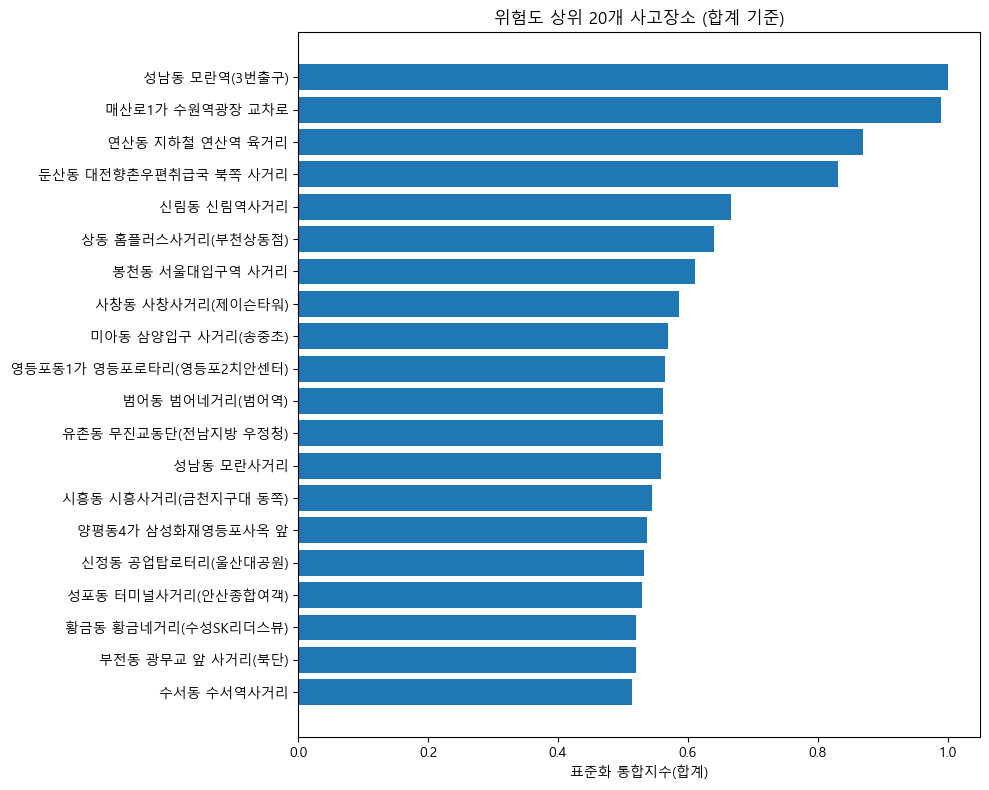

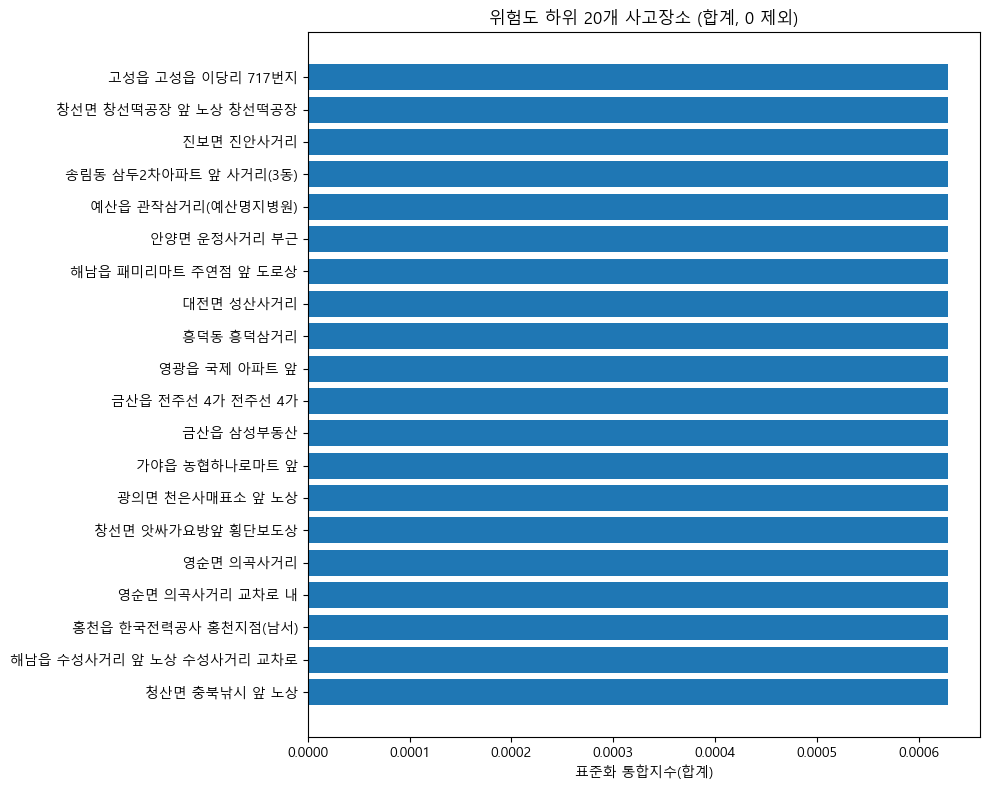

In [31]:
# %% [셀 10] 대표 개별 시각화 (Top/Bottom, 분포, 관계 등) — 필요하면 유지
# 상위 위험도 장소 Top20 (합계 기준)
plot_df = agg.sort_values('total_risk_sum_scaled', ascending=False).head(20)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(plot_df['사고장소'][::-1], plot_df['total_risk_sum_scaled'][::-1])
ax.set_xlabel('표준화 통합지수(합계)')
ax.set_title('위험도 상위 20개 사고장소 (합계 기준)')
fig.tight_layout(); fig.savefig(os.path.join(FIG_DIR, "top20_sum.png"), dpi=150, bbox_inches="tight")
plt.show()

# 하위 위험도(0 제외) Top20 (합계 기준)
METRIC = 'total_risk_sum_scaled'
plot_df = agg.loc[agg[METRIC] > 0].sort_values(METRIC, ascending=True).head(20)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(plot_df['사고장소'], plot_df[METRIC])
ax.set_xlabel('표준화 통합지수(합계)')
ax.set_title('위험도 하위 20개 사고장소 (합계, 0 제외)')
fig.tight_layout(); fig.savefig(os.path.join(FIG_DIR, "bottom20_sum_nonzero.png"), dpi=150, bbox_inches="tight")
plt.show()


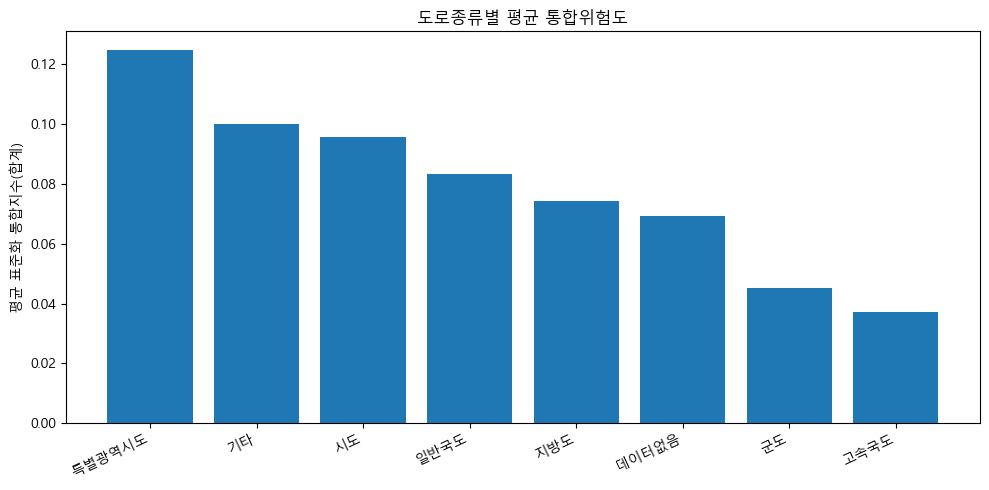

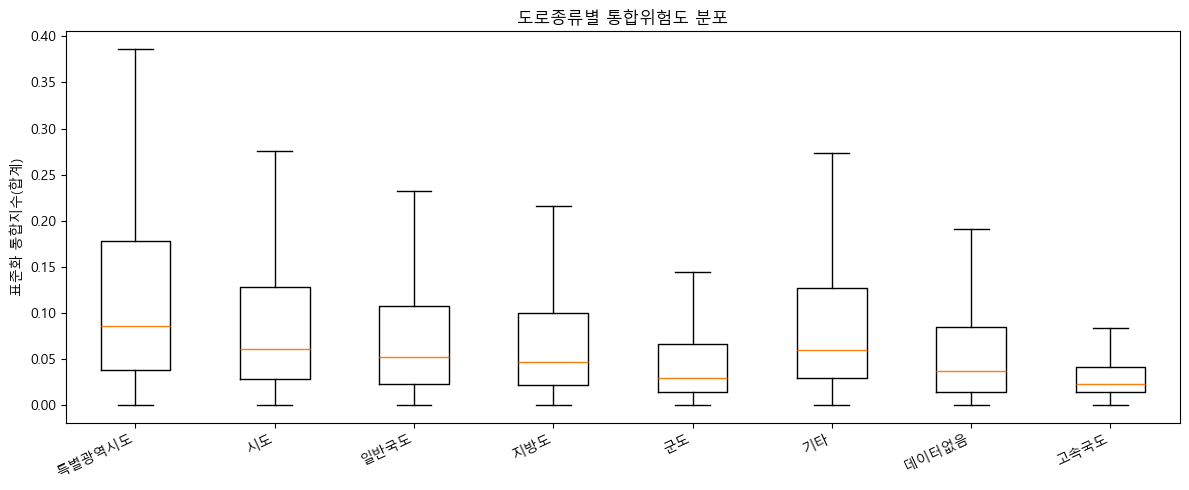

[도로종류] Kruskal–Wallis: H=38657.658, p=0, groups=8
  → 쌍대비 유의 쌍(Holm, α=0.05): 27/28

[도로종류] 요약
- 전체 평균 0.0787, 표준편차 0.0290
- 상위 3: 특별광역시도(0.1248), 기타(0.1001), 시도(0.0958)
- 하위 3: 데이터없음(0.0692), 군도(0.0451), 고속국도(0.0371)



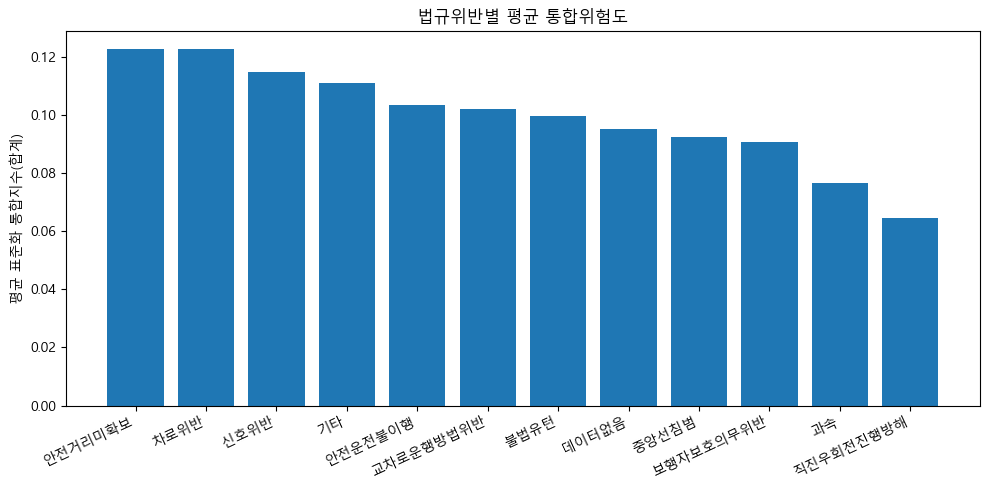

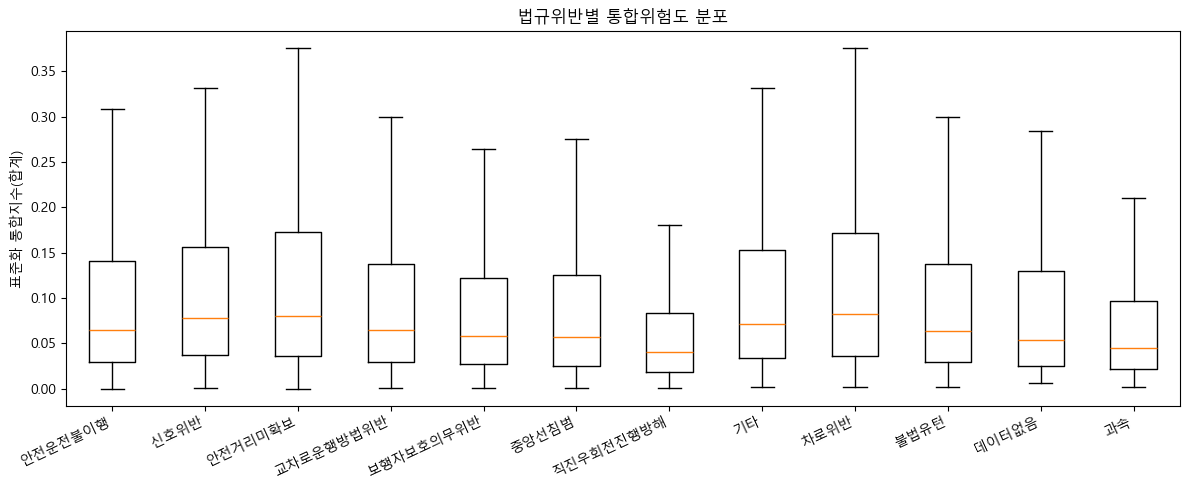

[법규위반] Kruskal–Wallis: H=9354.897, p=0, groups=12
  → 쌍대비 유의 쌍(Holm, α=0.05): 59/66

[법규위반] 요약
- 전체 평균 0.0995, 표준편차 0.0174
- 상위 3: 안전거리미확보(0.1225), 차로위반(0.1225), 신호위반(0.1145)
- 하위 3: 보행자보호의무위반(0.0905), 과속(0.0765), 직진우회전진행방해(0.0644)



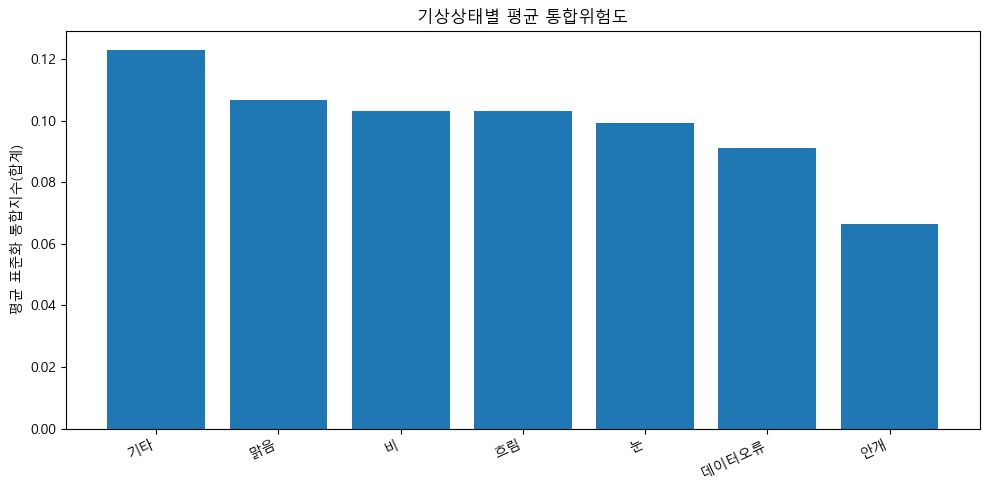

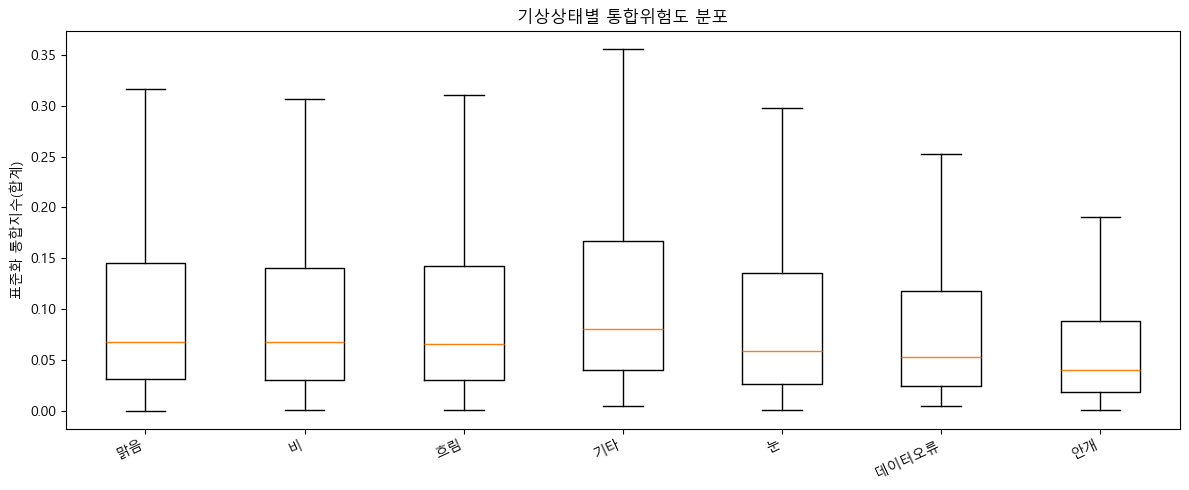

[기상상태] Kruskal–Wallis: H=304.463, p=9.04e-63, groups=7
  → 쌍대비 유의 쌍(Holm, α=0.05): 19/21

[기상상태] 요약
- 전체 평균 0.0989, 표준편차 0.0173
- 상위 3: 기타(0.1229), 맑음(0.1065), 비(0.1031)
- 하위 3: 눈(0.0993), 데이터오류(0.0913), 안개(0.0663)



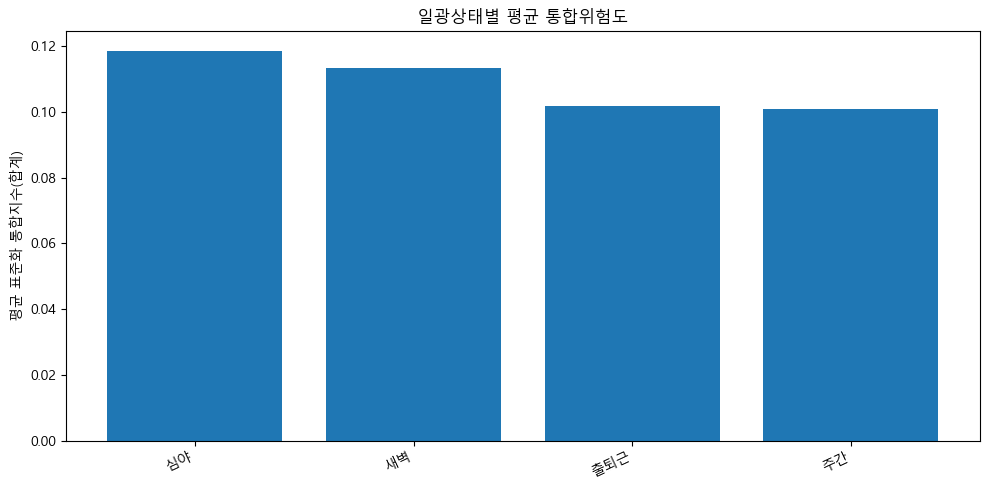

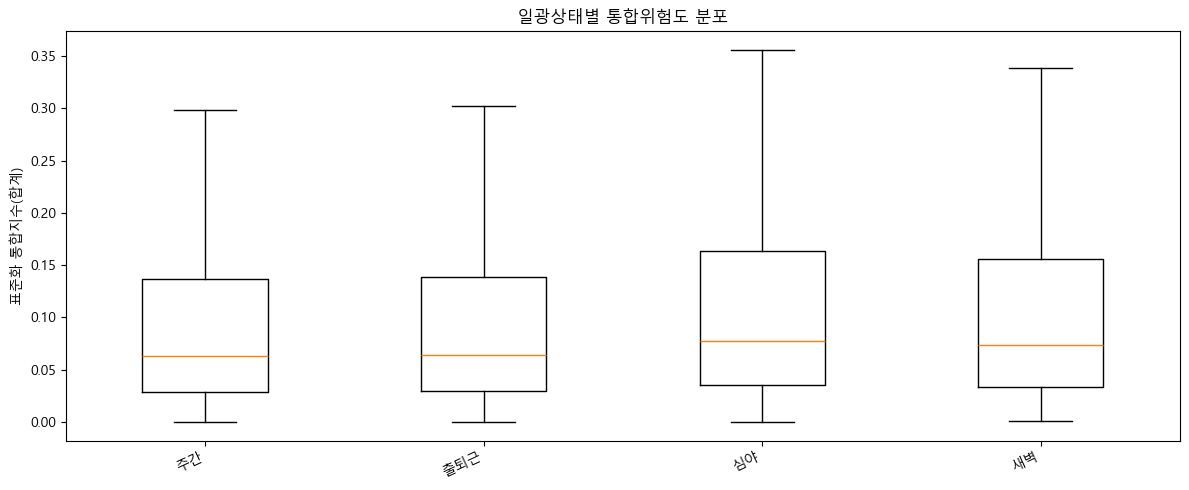

[일광상태] Kruskal–Wallis: H=4224.808, p=0, groups=4
  → 쌍대비 유의 쌍(Holm, α=0.05): 6/6

[일광상태] 요약
- 전체 평균 0.1086, 표준편차 0.0087
- 상위 3: 심야(0.1185), 새벽(0.1133), 출퇴근(0.1017)
- 하위 3: 새벽(0.1133), 출퇴근(0.1017), 주간(0.1010)



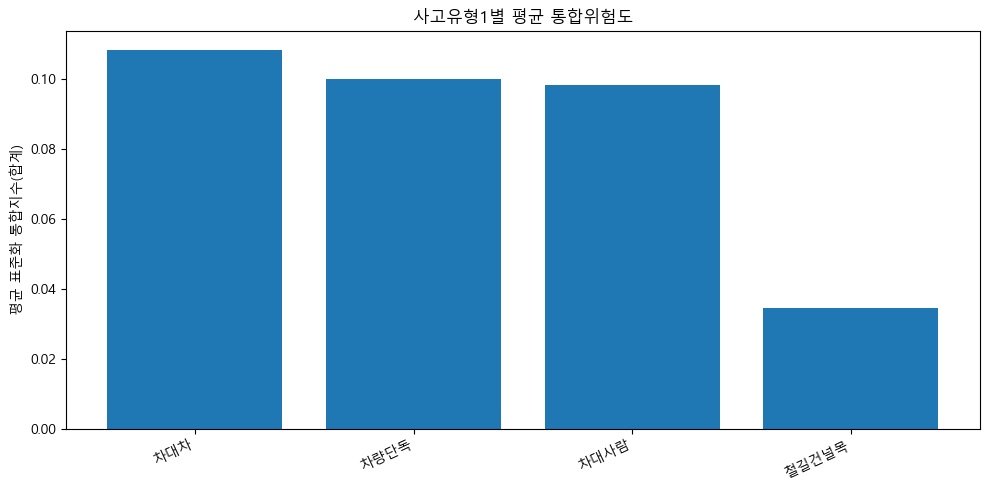

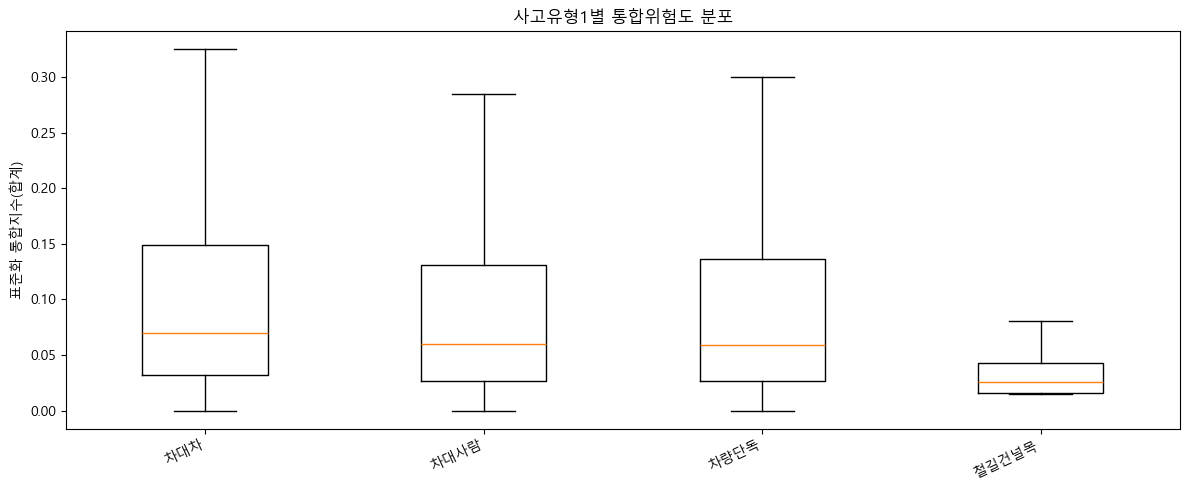

[사고유형1] Kruskal–Wallis: H=1998.562, p=0, groups=4
  → 쌍대비 유의 쌍(Holm, α=0.05): 2/6

[사고유형1] 요약
- 전체 평균 0.0853, 표준편차 0.0341
- 상위 3: 차대차(0.1082), 차량단독(0.1001), 차대사람(0.0982)
- 하위 3: 차량단독(0.1001), 차대사람(0.0982), 철길건널목(0.0346)



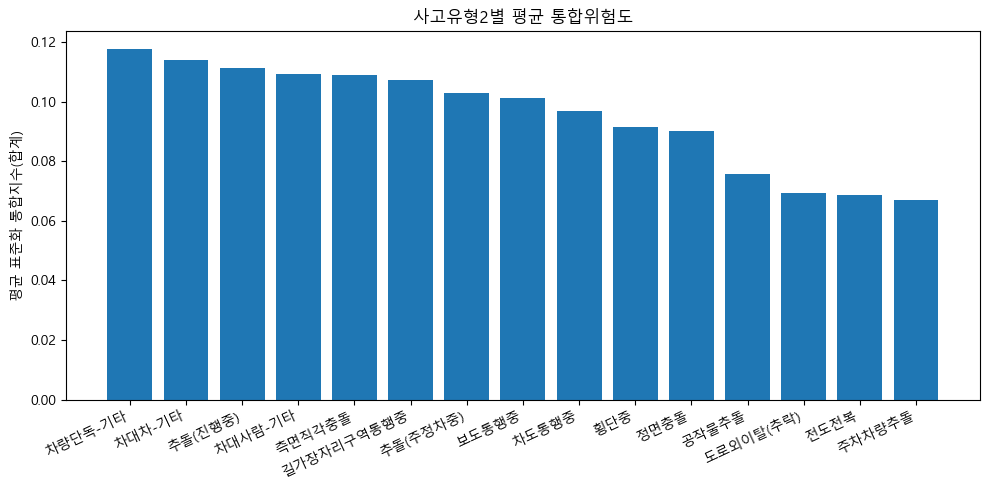

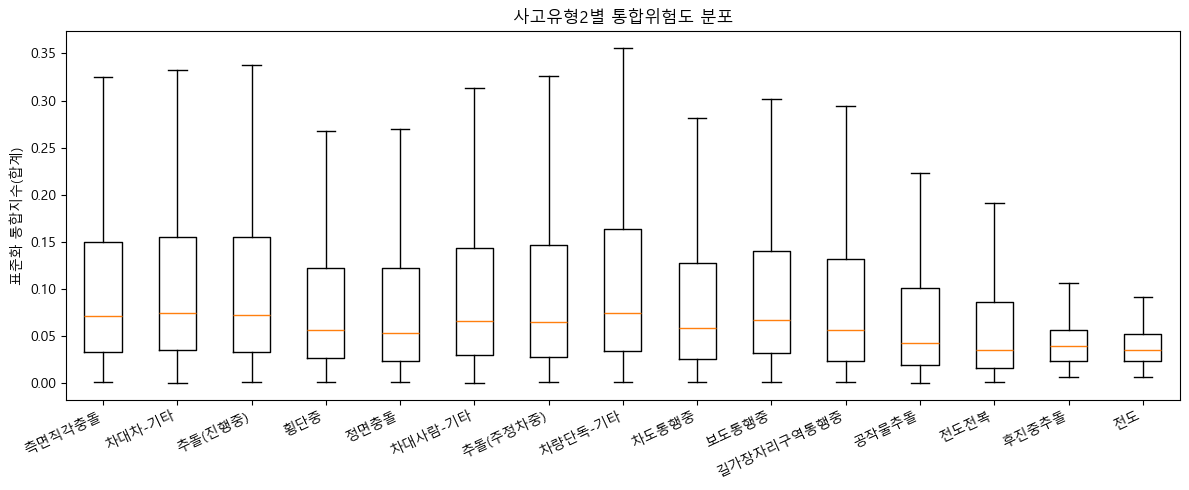

[사고유형2] Kruskal–Wallis: H=7403.464, p=0, groups=21
  → 쌍대비 유의 쌍(Holm, α=0.05): 94/105

[사고유형2] 요약
- 전체 평균 0.0802, 표준편차 0.0292
- 상위 3: 차량단독-기타(0.1177), 차대차-기타(0.1140), 추돌(진행중)(0.1114)
- 하위 3: 차단기돌파(0.0371), 전복(0.0341), 철길건널목-기타(0.0320)



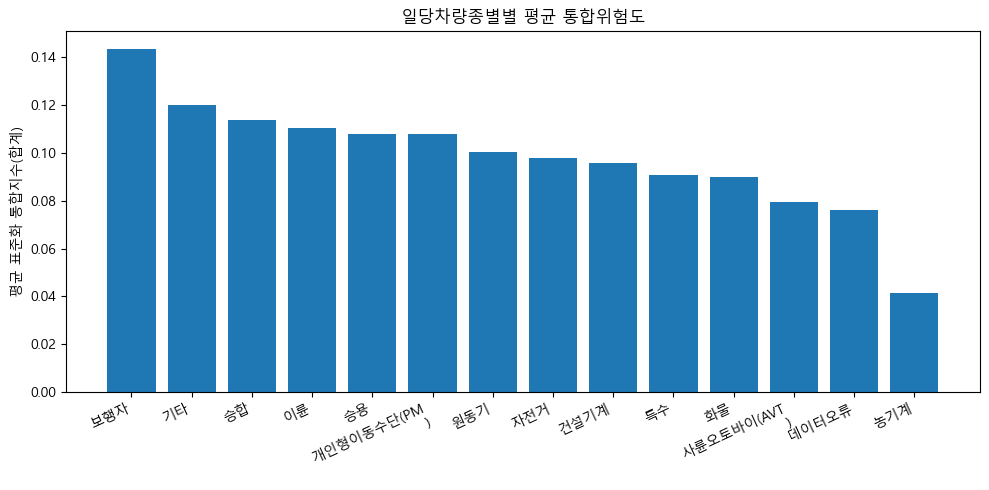

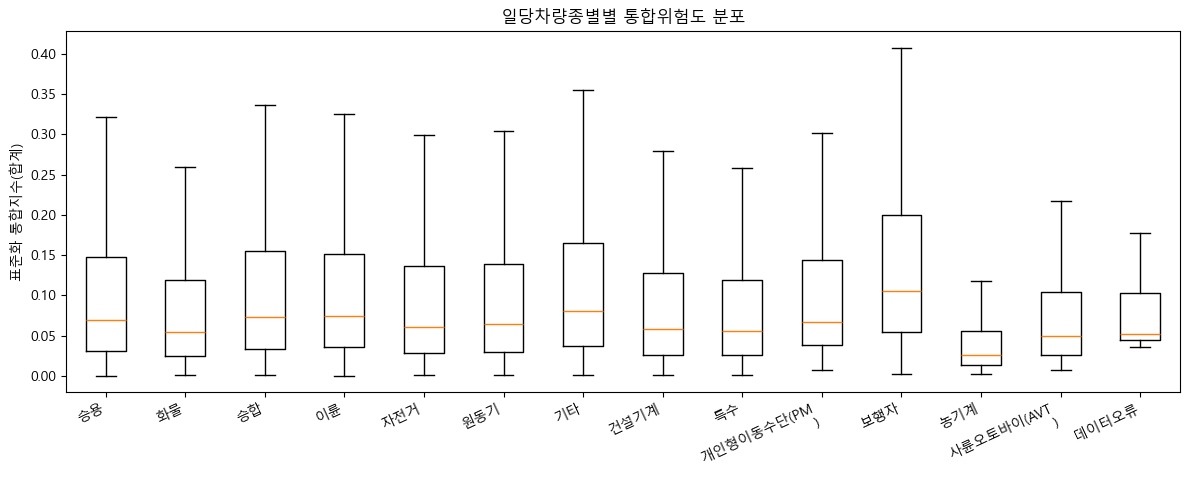

[일당차량종별] Kruskal–Wallis: H=3521.638, p=0, groups=14
  → 쌍대비 유의 쌍(Holm, α=0.05): 64/91

[일당차량종별] 요약
- 전체 평균 0.0982, 표준편차 0.0237
- 상위 3: 보행자(0.1436), 기타(0.1199), 승합(0.1136)
- 하위 3: 사륜오토바이(AVT)(0.0796), 데이터오류(0.0763), 농기계(0.0414)



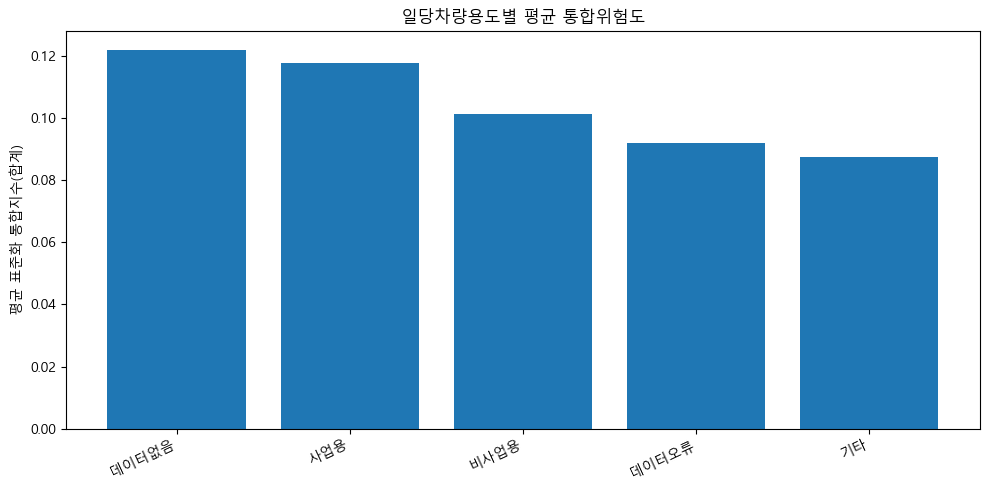

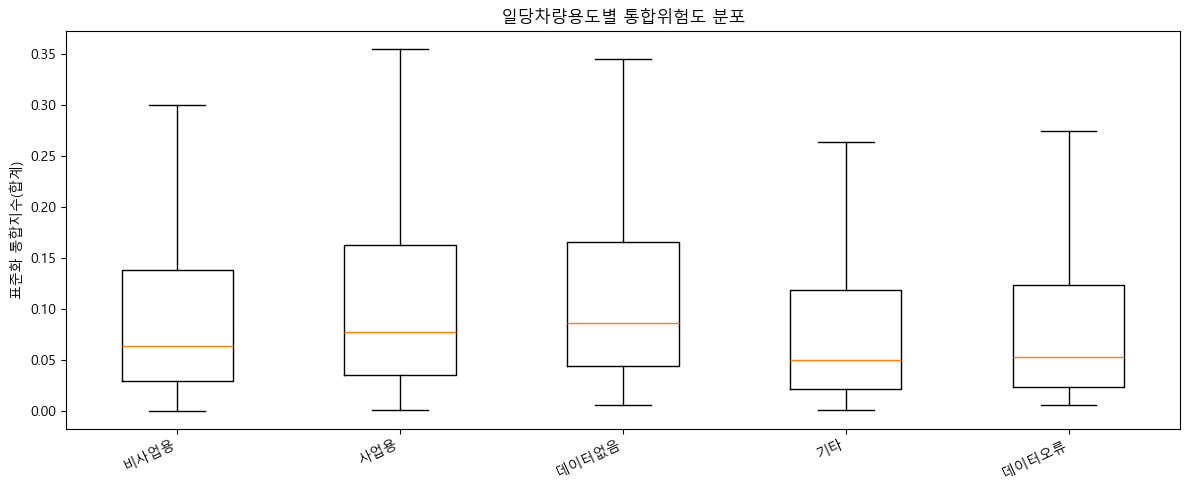

[일당차량용도] Kruskal–Wallis: H=6584.319, p=0, groups=5
  → 쌍대비 유의 쌍(Holm, α=0.05): 9/10

[일당차량용도] 요약
- 전체 평균 0.1041, 표준편차 0.0153
- 상위 3: 데이터없음(0.1219), 사업용(0.1178), 비사업용(0.1014)
- 하위 3: 비사업용(0.1014), 데이터오류(0.0919), 기타(0.0876)



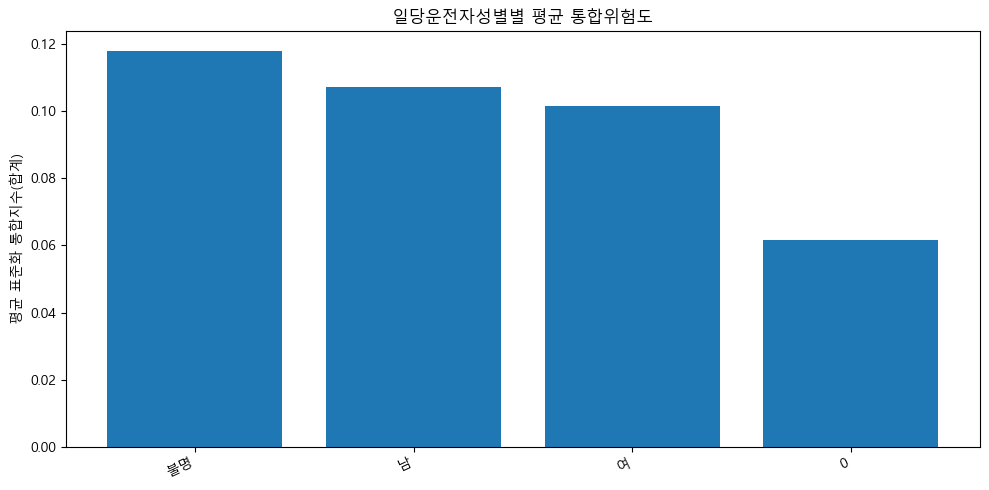

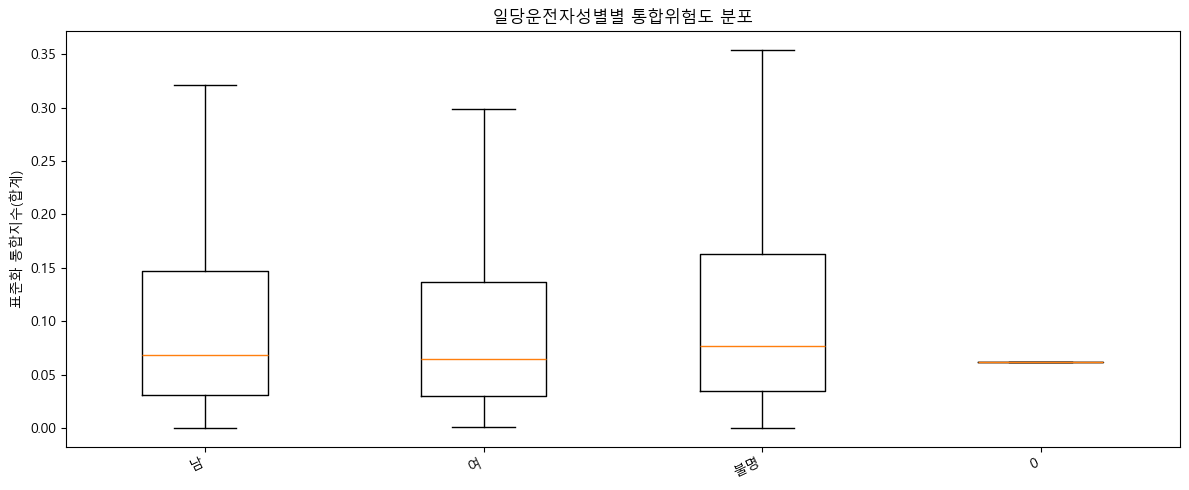

[일당운전자성별] Kruskal–Wallis: H=454.770, p=3.02e-98, groups=4
  → 쌍대비 유의 쌍(Holm, α=0.05): 3/6

[일당운전자성별] 요약
- 전체 평균 0.0971, 표준편차 0.0246
- 상위 3: 불명(0.1179), 남(0.1072), 여(0.1016)
- 하위 3: 남(0.1072), 여(0.1016), 0(0.0615)

완료: figs 폴더에 그래프/요약/쌍대비 CSV 저장


In [32]:
# %% [셀 11] 실행: 주요 범주형 전부를 자동 분석(시각화+요약+유의성)
target_cats = [
    "도로종류","법규위반","기상상태","일광상태",
    "사고유형1","사고유형2",
    "일당차량종별","일당차량용도","일당운전자성별"
]

for col in target_cats:
    if col in df_.columns:
        # 카테고리 수가 많은 것들만 topK로 제한해 계산량/가독성을 맞춤
        top = 15 if col in ["사고유형2","일당차량종별"] else None
        analyze_category(col, metric="total_risk_sum_scaled", topK=top, rotate=25, wrap=10,
                         do_pairwise=True, export_prefix=f"cat_{col}")
print("완료: figs 폴더에 그래프/요약/쌍대비 CSV 저장")


In [33]:
# %% 설정 통계 유틸(공용): Kruskal–Wallis, Mann–Whitney + Holm 보정
# - 기존에 정의돼 있다면 이 셀은 건너뛰어도 OK
from scipy import stats
import numpy as np
import pandas as pd

def kruskal_over_groups(df: pd.DataFrame, group_col: str, value_col: str):
    """
    다집단 비교: 그룹별 value 분포 차이 (Kruskal–Wallis)
    return: (H, p, k_groups)
    """
    if group_col not in df.columns or value_col not in df.columns:
        return np.nan, np.nan, 0
    groups = [g[value_col].dropna().values for _, g in df.groupby(group_col)]
    groups = [g for g in groups if len(g) > 0]
    if len(groups) < 2:
        return np.nan, np.nan, len(groups)
    H, p = stats.kruskal(*groups)
    return H, p, len(groups)

def pairwise_mw_holm(df: pd.DataFrame, group_col: str, value_col: str, max_pairs=50_000):
    """
    쌍대비: Mann–Whitney U(양측) + Holm 보정
    - group_col의 모든 조합(최대 max_pairs)을 테스트
    return: DataFrame [g1, g2, p_raw, p_holm, significant]
    """
    if group_col not in df.columns or value_col not in df.columns:
        return pd.DataFrame(columns=["g1","g2","p_raw","p_holm","significant"])
    cats = df[group_col].dropna().value_counts().index.tolist()
    total_pairs = len(cats) * (len(cats)-1) // 2
    if total_pairs > max_pairs:
        # n(n-1)/2 <= max_pairs 만족하는 최대 n만 사용(빈도 상위)
        n = int(np.floor((np.sqrt(1 + 8*max_pairs) - 1) / 2))
        cats = cats[:max(2, n)]

    rows = []
    for i in range(len(cats)):
        for j in range(i+1, len(cats)):
            a = df.loc[df[group_col]==cats[i], value_col].dropna().values
            b = df.loc[df[group_col]==cats[j], value_col].dropna().values
            if len(a)==0 or len(b)==0: 
                continue
            _, p = stats.mannwhitneyu(a, b, alternative="two-sided")
            rows.append((cats[i], cats[j], p))
    if not rows:
        return pd.DataFrame(columns=["g1","g2","p_raw","p_holm","significant"])

    res = pd.DataFrame(rows, columns=["g1","g2","p_raw"]).sort_values("p_raw").reset_index(drop=True)
    m = len(res)
    res["rank"] = np.arange(1, m+1)
    res["p_holm"] = np.minimum(1, (m - res["rank"] + 1) * res["p_raw"])
    res["significant"] = res["p_holm"] < 0.05
    return res[["g1","g2","p_raw","p_holm","significant"]]


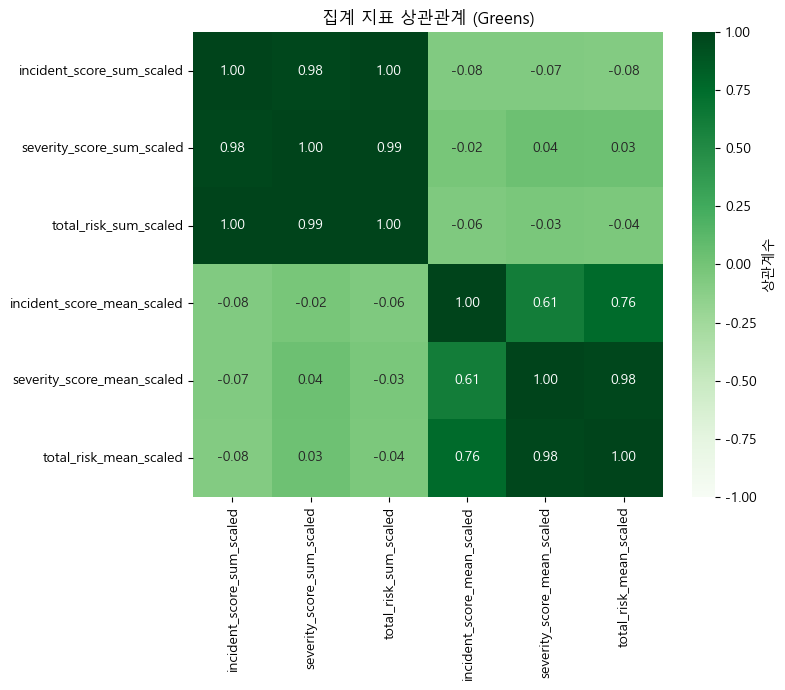

[상관 히트맵 요약]
- 강한 양의 상관 Top 3:
  · incident_score_sum_scaled vs total_risk_sum_scaled: r=0.998
  · severity_score_sum_scaled vs total_risk_sum_scaled: r=0.994
  · incident_score_sum_scaled vs severity_score_sum_scaled: r=0.984
- 강한 음의 상관 Top 3:
  · incident_score_sum_scaled vs total_risk_mean_scaled: r=-0.081
  · incident_score_sum_scaled vs incident_score_mean_scaled: r=-0.077
  · incident_score_sum_scaled vs severity_score_mean_scaled: r=-0.074


In [21]:
# %% [셀 12] 상관 히트맵 (Greens) + 자동 해석
# 목적: 핵심 지표 간의 구조적 상관을 한눈에 보고, 가장 강한 (+/-) 상관쌍을 텍스트로 요약
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_cols = [
    'incident_score_sum_scaled','severity_score_sum_scaled','total_risk_sum_scaled',
    'incident_score_mean_scaled','severity_score_mean_scaled','total_risk_mean_scaled'
]
corr = agg[corr_cols].corr()

plt.figure(figsize=(8, 7))
ax = sns.heatmap(
    corr, annot=True, fmt=".2f",
    cmap='Greens', vmin=-1, vmax=1,
    cbar_kws={'label':'상관계수'}
)
ax.set_title('집계 지표 상관관계 (Greens)')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "heatmap_corr_scaled_metrics.png"), dpi=150, bbox_inches="tight")
plt.show()

# --- 자동 해석: 상위 양/음의 상관쌍 출력 ---
pairs = []
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        pairs.append((corr_cols[i], corr_cols[j], corr.iloc[i, j]))
pairs_df = pd.DataFrame(pairs, columns=["x","y","r"]).sort_values("r", ascending=False)

top_pos = pairs_df.head(3)
top_neg = pairs_df.sort_values("r").head(3)

print("[상관 히트맵 요약]")
print("- 강한 양의 상관 Top 3:")
for _, row in top_pos.iterrows():
    print(f"  · {row['x']} vs {row['y']}: r={row['r']:.3f}")
print("- 강한 음의 상관 Top 3:")
for _, row in top_neg.iterrows():
    print(f"  · {row['x']} vs {row['y']}: r={row['r']:.3f}")


C:\Users\USER\AppData\Local\Temp\ipykernel_12164\3289433486.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index='사고요일', columns='사고시각', values='total_risk_sum_scaled', aggfunc='mean'))


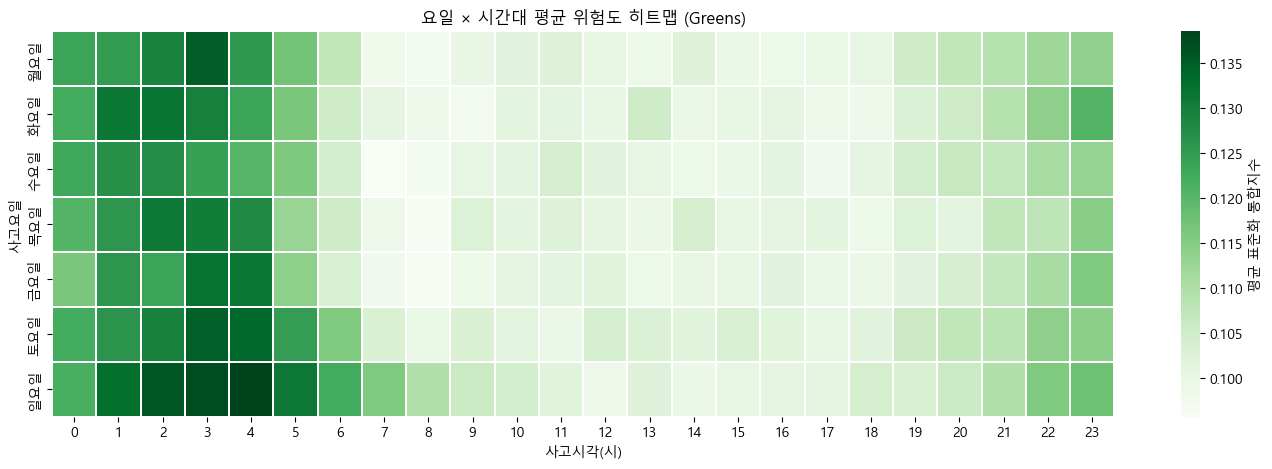

[요일×시간대 히트맵 요약] 상위 10 슬롯(평균 위험도 기준)
  · 일요일 04시: 0.1385
  · 일요일 03시: 0.1372
  · 일요일 02시: 0.1361
  · 월요일 03시: 0.1351
  · 토요일 03시: 0.1347
  · 토요일 04시: 0.1337
  · 일요일 01시: 0.1326
  · 금요일 03시: 0.1321
  · 화요일 02시: 0.1318
  · 화요일 01시: 0.1315


In [34]:
# %% [셀 13] 요일 × 시간대 히트맵 (Greens) + 자동 피크 요약
# 목적: 요일과 시간대 결합 패턴에서 고위험 슬롯 탐지
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 요일 순서 고정
day_order = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']

# 시각 정제
df_['사고시각'] = pd.to_numeric(df_['사고시각'], errors='coerce').astype('float')
df_ = df_.dropna(subset=['사고시각']).copy()
df_['사고시각'] = df_['사고시각'].astype(int).clip(0, 23)

# 피벗(평균 위험도)
pv = (df_
      .dropna(subset=['사고요일'])
      .assign(사고요일=lambda x: pd.Categorical(x['사고요일'], categories=day_order, ordered=True))
      .pivot_table(index='사고요일', columns='사고시각', values='total_risk_sum_scaled', aggfunc='mean'))

plt.figure(figsize=(14, 4.8))
ax = sns.heatmap(pv, cmap='Greens', linewidths=0.3, linecolor='white', cbar_kws={'label':'평균 표준화 통합지수'})
ax.set_title('요일 × 시간대 평균 위험도 히트맵 (Greens)')
ax.set_xlabel('사고시각(시)'); ax.set_ylabel('사고요일')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "heatmap_day_hour_mean_risk.png"), dpi=150, bbox_inches="tight")
plt.show()

# --- 자동 요약: 상위 K 슬롯 ---
K = 10
pv_flat = pv.stack().reset_index(name='mean_risk').sort_values('mean_risk', ascending=False).head(K)
print(f"[요일×시간대 히트맵 요약] 상위 {K} 슬롯(평균 위험도 기준)")
for _, r in pv_flat.iterrows():
    print(f"  · {r['사고요일']} {int(r['사고시각']):02d}시: {r['mean_risk']:.4f}")


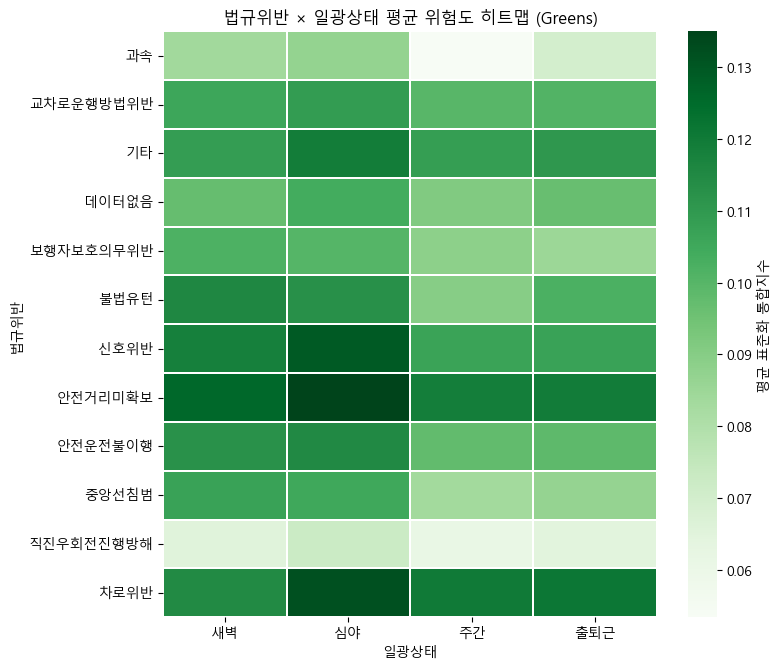

[법규위반×일광상태 히트맵 요약] 상위 12 조합
  · 안전거리미확보 × 심야: 0.1350
  · 차로위반 × 심야: 0.1320
  · 신호위반 × 심야: 0.1293
  · 안전거리미확보 × 새벽: 0.1258
  · 차로위반 × 출퇴근: 0.1212
  · 차로위반 × 주간: 0.1201
  · 안전거리미확보 × 출퇴근: 0.1196
  · 기타 × 심야: 0.1191
  · 안전거리미확보 × 주간: 0.1190
  · 신호위반 × 새벽: 0.1182
  · 불법유턴 × 새벽: 0.1156
  · 안전운전불이행 × 심야: 0.1152


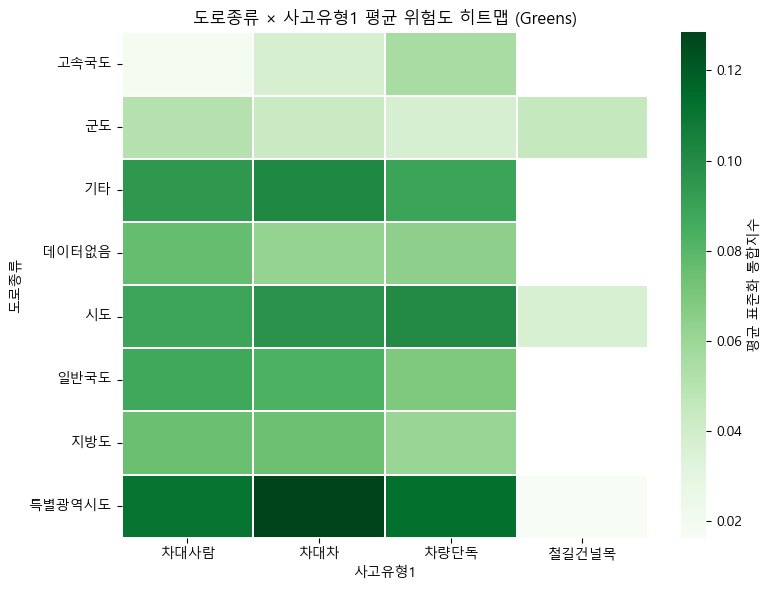

[도로종류×사고유형1 히트맵 요약] 상위 12 조합
  · 특별광역시도 × 차대차: 0.1285
  · 특별광역시도 × 차량단독: 0.1131
  · 특별광역시도 × 차대사람: 0.1113
  · 기타 × 차대차: 0.1024
  · 시도 × 차량단독: 0.1005
  · 시도 × 차대차: 0.0973
  · 기타 × 차대사람: 0.0951
  · 기타 × 차량단독: 0.0891
  · 시도 × 차대사람: 0.0888
  · 일반국도 × 차대사람: 0.0875
  · 일반국도 × 차대차: 0.0832
  · 데이터없음 × 차대사람: 0.0764


In [35]:
# %% [셀 14] 2-변수 조합 히트맵 (Greens) + 자동 상위 조합 요약
# 목적: 두 범주형 조합(예: 법규위반 × 일광상태)에서 높은 평균 위험 조합 탐지
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def two_way_heatmap(col1, col2, metric='total_risk_sum_scaled', topN=10, fname_prefix=None):
    tmp = df_.dropna(subset=[col1, col2])[[col1, col2, metric]].copy()
    if tmp.empty:
        print(f"[경고] {col1}×{col2}: 유효 데이터 없음")
        return
    pv = tmp.pivot_table(index=col1, columns=col2, values=metric, aggfunc='mean')
    plt.figure(figsize=(max(8, 0.5*len(pv.columns)+4), max(6, 0.4*len(pv.index)+2)))
    ax = sns.heatmap(pv, cmap='Greens', linewidths=0.3, linecolor='white',
                     cbar_kws={'label':'평균 표준화 통합지수'}, annot=False)
    ax.set_title(f'{col1} × {col2} 평균 위험도 히트맵 (Greens)')
    plt.tight_layout()
    prefix = fname_prefix or f"heatmap_{col1}_x_{col2}"
    plt.savefig(os.path.join(FIG_DIR, f"{prefix}.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # --- 자동 상위 조합 요약 ---
    flat = pv.stack().reset_index(name='mean_risk').dropna().sort_values('mean_risk', ascending=False).head(topN)
    print(f"[{col1}×{col2} 히트맵 요약] 상위 {len(flat)} 조합")
    for _, r in flat.iterrows():
        print(f"  · {r[col1]} × {r[col2]}: {r['mean_risk']:.4f}")

# 사용 예시 1) 법규위반 × 일광상태
two_way_heatmap('법규위반', '일광상태', topN=12, fname_prefix="heatmap_법규위반_x_일광상태")

# 사용 예시 2) 도로종류 × 사고유형1
two_way_heatmap('도로종류', '사고유형1', topN=12, fname_prefix="heatmap_도로종류_x_사고유형1")


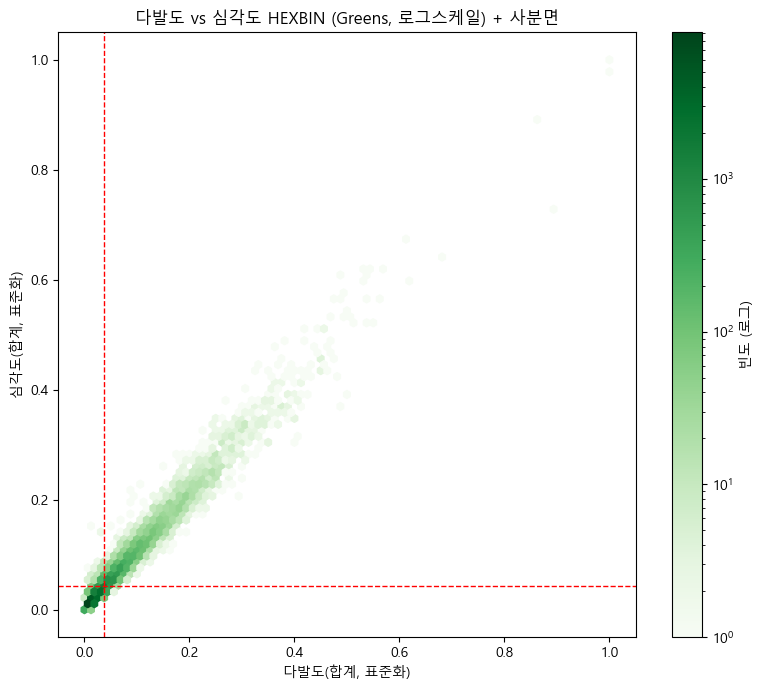

[HEXBIN 사분면 요약] (분모: 사고장소 수)
  · Q1 다발도↑ 심각도↑: 9255 (25.9%)
  · Q2 다발도↓ 심각도↑: 974 (2.7%)
  · Q3 다발도↓ 심각도↓: 24635 (68.9%)
  · Q4 다발도↑ 심각도↓: 877 (2.5%)


In [36]:
# %% [셀 15] 다발도 vs 심각도 HEXBIN (Greens) — 디테일 버전 + 사분면 요약
# 목적: (합계, 표준화) 다발도·심각도 공동 분포 밀도를 로그 색상으로 확인하고, 사분면별 분포 요약
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

xcol, ycol = 'incident_score_sum_scaled', 'severity_score_sum_scaled'
xm, ym = float(agg[xcol].mean()), float(agg[ycol].mean())

plt.figure(figsize=(8, 7))
hb = plt.hexbin(
    agg[xcol], agg[ycol],
    gridsize=80, cmap='Greens', mincnt=1, norm=mcolors.LogNorm()
)
cb = plt.colorbar(hb); cb.set_label('빈도 (로그)')
plt.axvline(xm, color='red', linestyle='--', linewidth=1)
plt.axhline(ym, color='red', linestyle='--', linewidth=1)
plt.xlabel('다발도(합계, 표준화)'); plt.ylabel('심각도(합계, 표준화)')
plt.title('다발도 vs 심각도 HEXBIN (Greens, 로그스케일) + 사분면')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "hexbin_incident_vs_severity_quadrant.png"), dpi=150, bbox_inches="tight")
plt.show()

# --- 사분면 요약: 평균선을 기준으로 4분면 빈도 ---
q1 = ((agg[xcol] >= xm) & (agg[ycol] >= ym)).sum()  # 다발도↑ 심각도↑
q2 = ((agg[xcol] <  xm) & (agg[ycol] >= ym)).sum()  # 다발도↓ 심각도↑
q3 = ((agg[xcol] <  xm) & (agg[ycol] <  ym)).sum()  # 다발도↓ 심각도↓
q4 = ((agg[xcol] >= xm) & (agg[ycol] <  ym)).sum()  # 다발도↑ 심각도↓

total_pts = len(agg)
print("[HEXBIN 사분면 요약] (분모: 사고장소 수)")
print(f"  · Q1 다발도↑ 심각도↑: {q1} ({q1/total_pts:.1%})")
print(f"  · Q2 다발도↓ 심각도↑: {q2} ({q2/total_pts:.1%})")
print(f"  · Q3 다발도↓ 심각도↓: {q3} ({q3/total_pts:.1%})")
print(f"  · Q4 다발도↑ 심각도↓: {q4} ({q4/total_pts:.1%})")


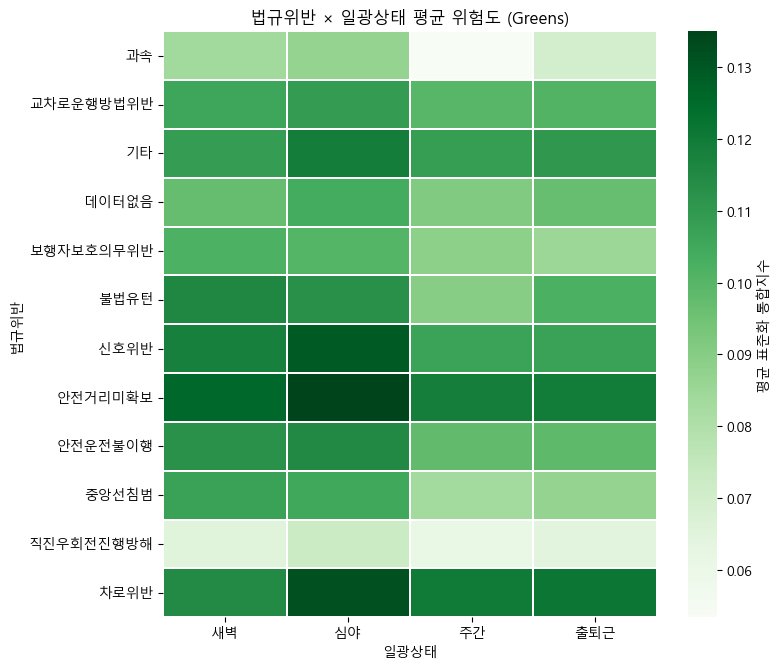

[법규위반×일광상태 유의성 요약]
- 행 기준(= 법규위반 고정, 일광상태 차이 유의): 11/12
- 열 기준(= 일광상태 고정, 법규위반 차이 유의): 4/4
- 쌍대비 CSV: figs\heatmap_stat_법규위반_x_일광상태_row_과속_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_교차로운행방법위반_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_기타_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_보행자보호의무위반_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_불법유턴_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_신호위반_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_안전거리미확보_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_안전운전불이행_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_중앙선침범_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_직진우회전진행방해_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_row_차로위반_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_col_새벽_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_col_심야_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_col_주간_pairwise.csv figs\heatmap_stat_법규위반_x_일광상태_col_출퇴근_pairwise.csv
- 평균 위험 상위 10 조합:
  · 법규위반=안전거리미확보 × 일광상태=심야: 0.1350
  · 법규위반=차로위반 × 일광상태=심야: 0.1320
  · 법규위반=신호위반 × 일광상태=심

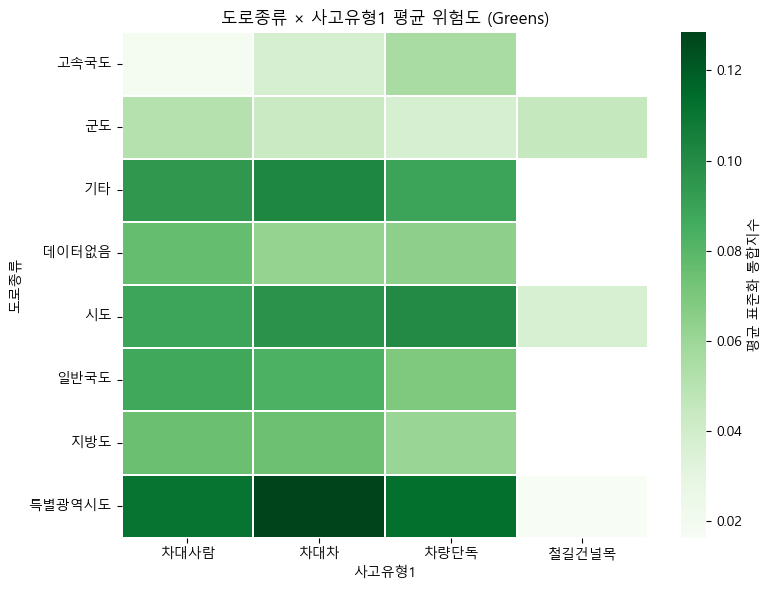

[도로종류×사고유형1 유의성 요약]
- 행 기준(= 도로종류 고정, 사고유형1 차이 유의): 8/8
- 열 기준(= 사고유형1 고정, 도로종류 차이 유의): 3/4
- 쌍대비 CSV: figs\heatmap_stat_도로종류_x_사고유형1_row_고속국도_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_row_군도_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_row_기타_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_row_데이터없음_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_row_시도_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_row_일반국도_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_row_지방도_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_row_특별광역시도_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_col_차대사람_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_col_차대차_pairwise.csv figs\heatmap_stat_도로종류_x_사고유형1_col_차량단독_pairwise.csv
- 평균 위험 상위 10 조합:
  · 도로종류=특별광역시도 × 사고유형1=차대차: 0.1285
  · 도로종류=특별광역시도 × 사고유형1=차량단독: 0.1131
  · 도로종류=특별광역시도 × 사고유형1=차대사람: 0.1113
  · 도로종류=기타 × 사고유형1=차대차: 0.1024
  · 도로종류=시도 × 사고유형1=차량단독: 0.1005
  · 도로종류=시도 × 사고유형1=차대차: 0.0973
  · 도로종류=기타 × 사고유형1=차대사람: 0.0951
  · 도로종류=기타 × 사고유형1=차량단독: 0.0891
  · 도로종류=시도 × 사고유형1=차대사람: 0.

In [37]:
# %% [셀 16] 2-범주 조합 히트맵 + 유의성(행/열 Kruskal, 쌍대비 Holm) + 요약/CSV 저장
import seaborn as sns
import matplotlib.pyplot as plt

def two_way_heatmap_with_stats(col1, col2, metric='total_risk_sum_scaled',
                               row_topK=None, col_topK=None, fname_prefix=None):
    """
    col1 × col2 조합 히트맵 + 각 행/열에 대해
    - Kruskal–Wallis(전체)
    - p<0.05면 쌍대 Mann–Whitney + Holm 보정
    row_topK, col_topK: 카테고리 수가 너무 많을 때 빈도 상위 N개로 제한(가독성/속도)
    """
    tmp = df_[[col1, col2, metric]].dropna().copy()
    if tmp.empty:
        print(f"[경고] {col1}×{col2}: 유효 데이터 없음")
        return

    # 빈도 상위 제한
    if row_topK:
        keep_rows = tmp[col1].value_counts().index[:row_topK]
        tmp = tmp[tmp[col1].isin(keep_rows)]
    if col_topK:
        keep_cols = tmp[col2].value_counts().index[:col_topK]
        tmp = tmp[tmp[col2].isin(keep_cols)]

    # 피벗 (평균)
    pv = tmp.pivot_table(index=col1, columns=col2, values=metric, aggfunc='mean')

    # 히트맵
    plt.figure(figsize=(max(8, 0.5*len(pv.columns)+4), max(6, 0.4*len(pv.index)+2)))
    ax = sns.heatmap(pv, cmap='Greens', linewidths=0.3, linecolor='white',
                     cbar_kws={'label':'평균 표준화 통합지수'}, annot=False)
    ax.set_title(f'{col1} × {col2} 평균 위험도 (Greens)')
    plt.tight_layout()
    prefix = fname_prefix or f"heatmap_{col1}_x_{col2}"
    plt.savefig(os.path.join(FIG_DIR, f"{prefix}.png"), dpi=150, bbox_inches="tight")
    plt.show()

    # 유의성: 행별(= col2에 따른 차이)
    row_tests, row_pair_csvs = [], []
    for r in pv.index:
        sub = tmp.loc[tmp[col1]==r, [col2, metric]].rename(columns={col2:"grp", metric:"val"})
        H, p, k = kruskal_over_groups(sub, "grp", "val")
        row_tests.append((r, H, p, k))
        if k>=2 and (not np.isnan(p)) and p<0.05:
            pw = pairwise_mw_holm(sub, "grp", "val")
            if not pw.empty:
                f = os.path.join(FIG_DIR, f"{prefix}_row_{str(r)}_pairwise.csv")
                pw.to_csv(f, index=False, encoding="utf-8"); row_pair_csvs.append(f)

    # 유의성: 열별(= col1에 따른 차이)
    col_tests, col_pair_csvs = [], []
    for c in pv.columns:
        sub = tmp.loc[tmp[col2]==c, [col1, metric]].rename(columns={col1:"grp", metric:"val"})
        H, p, k = kruskal_over_groups(sub, "grp", "val")
        col_tests.append((c, H, p, k))
        if k>=2 and (not np.isnan(p)) and p<0.05:
            pw = pairwise_mw_holm(sub, "grp", "val")
            if not pw.empty:
                f = os.path.join(FIG_DIR, f"{prefix}_col_{str(c)}_pairwise.csv")
                pw.to_csv(f, index=False, encoding="utf-8"); col_pair_csvs.append(f)

    # 요약 출력 + 저장
    sig_rows = [(r,H,p,k) for (r,H,p,k) in row_tests if (not np.isnan(p)) and p<0.05]
    sig_cols = [(c,H,p,k) for (c,H,p,k) in col_tests if (not np.isnan(p)) and p<0.05]
    print(f"[{col1}×{col2} 유의성 요약]")
    print(f"- 행 기준(= {col1} 고정, {col2} 차이 유의): {len(sig_rows)}/{len(row_tests)}")
    print(f"- 열 기준(= {col2} 고정, {col1} 차이 유의): {len(sig_cols)}/{len(col_tests)}")

    pd.DataFrame(row_tests, columns=[col1,"H","p","k_groups"]).to_csv(os.path.join(FIG_DIR, f"{prefix}_rowtests.csv"), index=False, encoding="utf-8")
    pd.DataFrame(col_tests, columns=[col2,"H","p","k_groups"]).to_csv(os.path.join(FIG_DIR, f"{prefix}_coltests.csv"), index=False, encoding="utf-8")
    if row_pair_csvs or col_pair_csvs:
        print("- 쌍대비 CSV:", *(row_pair_csvs + col_pair_csvs))
    else:
        print("- 쌍대비 CSV: (없음)")

    # 상위 조합 TopN(기본 10) 리포팅
    TopN = 10
    flat = pv.stack().reset_index(name='mean_risk').dropna().sort_values('mean_risk', ascending=False).head(TopN)
    print(f"- 평균 위험 상위 {TopN} 조합:")
    for _, r in flat.iterrows():
        print(f"  · {col1}={r[col1]} × {col2}={r[col2]}: {r['mean_risk']:.4f}")

# 사용 예시 1) 법규위반 × 일광상태 (행/열 쌍대비 CSV 포함)
two_way_heatmap_with_stats("법규위반", "일광상태", row_topK=None, col_topK=None, fname_prefix="heatmap_stat_법규위반_x_일광상태")

# 사용 예시 2) 도로종류 × 사고유형1 (카테고리 수가 많으면 topK로 제한 권장)
two_way_heatmap_with_stats("도로종류", "사고유형1", row_topK=None, col_topK=12, fname_prefix="heatmap_stat_도로종류_x_사고유형1")


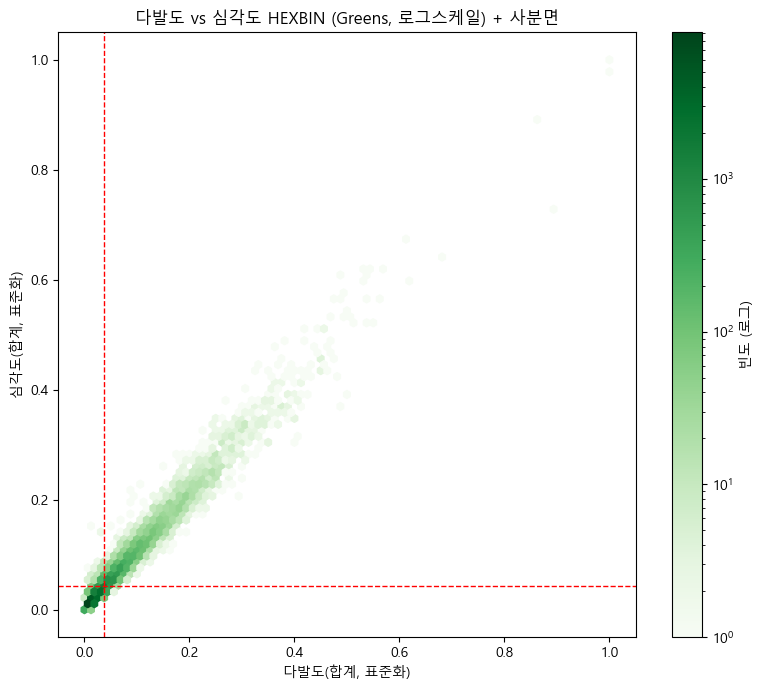

[HEXBIN 사분면 요약]
  · Q1 다발도↑ 심각도↑: 9255 (25.9%)
  · Q2 다발도↓ 심각도↑: 974 (2.7%)
  · Q3 다발도↓ 심각도↓: 24635 (68.9%)
  · Q4 다발도↑ 심각도↓: 877 (2.5%)


In [38]:
# %% [셀 17] 다발도 vs 심각도 HEXBIN (Greens) + 사분면 요약 (유지)

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

xcol, ycol = 'incident_score_sum_scaled', 'severity_score_sum_scaled'
xm, ym = float(agg[xcol].mean()), float(agg[ycol].mean())

plt.figure(figsize=(8, 7))
hb = plt.hexbin(agg[xcol], agg[ycol], gridsize=80, cmap='Greens', mincnt=1, norm=mcolors.LogNorm())
cb = plt.colorbar(hb); cb.set_label('빈도 (로그)')
plt.axvline(xm, color='red', linestyle='--', linewidth=1)
plt.axhline(ym, color='red', linestyle='--', linewidth=1)
plt.xlabel('다발도(합계, 표준화)'); plt.ylabel('심각도(합계, 표준화)')
plt.title('다발도 vs 심각도 HEXBIN (Greens, 로그스케일) + 사분면')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "hexbin_incident_vs_severity_quadrant.png"), dpi=150, bbox_inches="tight")
plt.show()

q1 = ((agg[xcol] >= xm) & (agg[ycol] >= ym)).sum()
q2 = ((agg[xcol] <  xm) & (agg[ycol] >= ym)).sum()
q3 = ((agg[xcol] <  xm) & (agg[ycol] <  ym)).sum()
q4 = ((agg[xcol] >= xm) & (agg[ycol] <  ym)).sum()
total_pts = len(agg)
print("[HEXBIN 사분면 요약]")
print(f"  · Q1 다발도↑ 심각도↑: {q1} ({q1/total_pts:.1%})")
print(f"  · Q2 다발도↓ 심각도↑: {q2} ({q2/total_pts:.1%})")
print(f"  · Q3 다발도↓ 심각도↓: {q3} ({q3/total_pts:.1%})")
print(f"  · Q4 다발도↑ 심각도↓: {q4} ({q4/total_pts:.1%})")


In [39]:
# %% [셀 18] 보고서 문단 생성 유틸: 카테고리별 해석 문장 자동 생성
import os
import numpy as np
import pandas as pd

def _fmt(x, fmt=".4f"):
    try:
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return "nan"
        return format(x, fmt)
    except Exception:
        return str(x)

def build_category_report_paragraph(df_source: pd.DataFrame, col: str, metric: str,
                                    topK_for_plot=None, topn_list=3) -> str:
    """
    df_source : df_ (브로드캐스트된 데이터프레임 권장)
    col       : 범주형 컬럼명 (예: '법규위반')
    metric    : 지표 컬럼명 (예: 'total_risk_sum_scaled')
    topK_for_plot : 시각화 등에서 제한했던 상위 N (문단엔 전체 통계 사용)
    topn_list : Top/Bottom 나열 개수
    return    : 한국어 보고서용 문단(str)
    """
    # 유효성 체크
    if col not in df_source.columns:
        return f"**[{col}]**: 분석 불가(컬럼 없음)."
    if metric not in df_source.columns:
        return f"**[{col}]**: 분석 불가(지표 '{metric}' 없음)."

    tmp = df_source.dropna(subset=[col])[[col, metric]].copy()
    if tmp.empty:
        return f"**[{col}]**: 분석 불가(유효 데이터 없음)."

    # 전체 평균/표준편차
    overall_mean = float(tmp[metric].mean())
    overall_std  = float(tmp[metric].std())
    groups = tmp[col].dropna().unique()
    k_groups = len(groups)

    # 카테고리 평균 정렬(전체 기준으로)
    mean_s_all = tmp.groupby(col)[metric].mean().sort_values(ascending=False)

    # 상/하위 목록
    k = min(topn_list, len(mean_s_all))
    top_items = ", ".join([f"{idx}({_fmt(val)})" for idx, val in mean_s_all.head(k).items()])
    bottom_items = ", ".join([f"{idx}({_fmt(val)})" for idx, val in mean_s_all.tail(k).items()])

    # 유의성: 전체 + 쌍대비(앞서 정의한 함수 활용)
    H, p_overall, _ = kruskal_over_groups(tmp.rename(columns={col:"grp", metric:"val"}), "grp", "val")
    pair_text = ""
    if not (isinstance(p_overall, float) and np.isnan(p_overall)) and p_overall < 0.05:
        # 시각화에서 topK 제한을 걸었던 경우, 쌍대비는 동일 기준의 상위 카테고리로 제한 (계산량/가독성)
        if topK_for_plot:
            keep = tmp[col].value_counts().index[:topK_for_plot]
            tmp_pw = tmp[tmp[col].isin(keep)].rename(columns={col:"grp", metric:"val"})
        else:
            tmp_pw = tmp.rename(columns={col:"grp", metric:"val"})
        pw_df = pairwise_mw_holm(tmp_pw, "grp", "val")
        if not pw_df.empty:
            pair_text = f"쌍대비 Mann–Whitney(α=0.05, Holm 보정) 결과 {int(pw_df['significant'].sum())}/{len(pw_df)}쌍이 유의함."
        else:
            pair_text = "쌍대비 계산 가능한 유효 쌍이 없음."
    elif isinstance(p_overall, float) and np.isnan(p_overall):
        pair_text = "그룹 수 또는 표본 부족으로 유의성 검정 불가."
    else:
        pair_text = "전체 유의성 없음(p≥0.05)으로 쌍대비 생략."

    paragraph = (
        f"**[{col}] 분석 결과 요약**  \n"
        f"Kruskal–Wallis 검정 결과, {col}별 표준화 통합위험도(합계) 분포는 "
        f"{'통계적으로 유의한 차이가 있는 것으로 나타났다' if (not (isinstance(p_overall,float) and np.isnan(p_overall)) and p_overall < 0.05) else '유의하지 않았다'}"
        f"(H={_fmt(H,'.3f')}, p={_fmt(p_overall,'.3g')}, 그룹={k_groups}개). "
        f"전체 평균은 {_fmt(overall_mean,'.4f')}(표준편차 {_fmt(overall_std,'.4f')})이며, "
        f"위험도가 높은 상위 {k}개 유형은 {top_items}, 낮은 {k}개 유형은 {bottom_items}로 확인된다. "
        f"{pair_text}"
    )
    return paragraph


In [40]:
# %% [셀 19] 보고서 문단 일괄 생성/저장 (Markdown)
REPORT_MD = os.path.join(FIG_DIR, "report_paragraphs.md")
sections = []

# 시각화 루프에서 쓰던 대상과 동일하게 사용 (원하면 목록 바꿔도 OK)
target_cats = [
    "도로종류","법규위반","기상상태","일광상태",
    "사고유형1","사고유형2",
    "일당차량종별","일당차량용도","일당운전자성별"
]

for col in target_cats:
    if col in df_.columns:
        # 시각화에서 topK를 걸었던 컬럼은 동일 값 사용(없으면 None)
        topK_hint = 15 if col in ["사고유형2","일당차량종별"] else None
        para = build_category_report_paragraph(df_, col, metric="total_risk_sum_scaled",
                                               topK_for_plot=topK_hint, topn_list=3)
        sections.append(para)

# Markdown 파일로 저장
with open(REPORT_MD, "w", encoding="utf-8") as f:
    f.write("# TMACS 범주형 분석 보고서 문단\n\n")
    for s in sections:
        f.write(s + "\n\n")

print(f"보고서 문단 저장 완료: {REPORT_MD}")


보고서 문단 저장 완료: figs\report_paragraphs.md
